In [ ]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 52924, done.
remote: Total 52924 (delta 0), reused 0 (delta 0), pack-reused 52924
Receiving objects: 100% (52924/52924), 569.32 MiB | 32.56 MiB/s, done.
Resolving deltas: 100% (36250/36250), done.


In [ ]:
%cd /content/models/research/
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

/content/models/research
Processing /content/models/research
     |████████████████████████████████| 9.0MB 10.4MB/s 
     |████████████████████████████████| 358kB 47.2MB/s 
     |████████████████████████████████| 1.1MB 56.9MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 17.7MB 180kB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 2.2MB 45.4MB/s 
     |████████████████████████████████| 829kB 46.0MB/s 
     |████████████████████████████████| 153kB 50.9MB/s 
     |████████████████████████████████| 645kB 47.2MB/s 
     |████████████████████████████████| 51kB 9.9MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 174kB 58.5MB/s 
     |████████████████████████████████| 37.6MB 86kB/s 
     |████████████████████████████████| 706kB 45.7MB/s 
     |████████████████████████████████| 1.2MB 44.7MB/s 
     |████████████████████████████████| 112kB 57.

In [ ]:
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

2021-03-05 08:19:40.226058: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-03-05 08:19:42.955026: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-05 08:19:42.956052: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-05 08:19:43.023413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-05 08:19:43.024029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB devi

### Preparing Dataset

In [ ]:
%cd /content/
!wget --header="Host: mycityreport.s3-ap-northeast-1.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,mr;q=0.8" --header="Referer: https://github.com/sekilab/RoadDamageDetector" "https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz" -c -O 'train.tar.gz'

/content
--2021-03-05 08:20:13--  https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz
Resolving mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)... 52.219.16.163
Connecting to mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)|52.219.16.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472626254 (1.4G) [application/x-tar]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   1.37G  32.9MB/s    in 43s     

2021-03-05 08:20:56 (32.4 MB/s) - ‘train.tar.gz’ saved [1472626254/1472626254]



In [ ]:
!tar -zxf ./train.tar.gz -C /content/

In [ ]:
!mkdir /content/data
!mkdir /content/data/train
!mkdir /content/data/val
!mkdir /content/data/test
!mv /content/train/label_map.pbtxt /content/data/

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
from xml.etree import ElementTree
from sklearn.model_selection import train_test_split

base_dir = '/content/train/'
countries = ['Czech', 'India', 'Japan']
labels = ['D00', 'D10', 'D20', 'D40']

image_xml_dirs = []
 
for c in countries:
  xml_files = sorted(os.listdir(base_dir+c+'/annotations/xmls/'))
  image_files = sorted(os.listdir(base_dir+c+'/images/'))
  
  #Considering images which have objetcs
  for i in range(len(xml_files)):
    infile_xml = open(base_dir+c+'/annotations/xmls/'+xml_files[i])
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    if root.find('object'):   
      #checking whether that image has atleast one label that are we are looking for 
      classes = []
      for obj in root.iter('object'):
        classes.append(obj.find('name').text)
      if any(i in labels for i in classes):
        image_xml_dirs.append([base_dir+c+'/annotations/xmls/'+xml_files[i], \
                                base_dir+c+'/images/'+image_files[i]])

image_xml_dirs = np.array(image_xml_dirs)
print('Total images with objects:',len(image_xml_dirs))
print(image_xml_dirs[:5])

Total images with objects: 12195
[['/content/train/Czech/annotations/xmls/Czech_000006.xml'
  '/content/train/Czech/images/Czech_000006.jpg']
 ['/content/train/Czech/annotations/xmls/Czech_000010.xml'
  '/content/train/Czech/images/Czech_000010.jpg']
 ['/content/train/Czech/annotations/xmls/Czech_000020.xml'
  '/content/train/Czech/images/Czech_000020.jpg']
 ['/content/train/Czech/annotations/xmls/Czech_000021.xml'
  '/content/train/Czech/images/Czech_000021.jpg']
 ['/content/train/Czech/annotations/xmls/Czech_000022.xml'
  '/content/train/Czech/images/Czech_000022.jpg']]


In [ ]:
train, val = train_test_split(image_xml_dirs, test_size=0.2, random_state=42)
val, test = train_test_split(val, test_size=0.5, random_state=42)

print('no of images for training', len(train))
print('no of images for validation', len(val))
print('no of images for testing', len(test))

no of images for training 9756
no of images for validation 1219
no of images for testing 1220


In [ ]:
def move_files(files, dest):
  for i in files:
    shutil.move(i[0], dest)
    shutil.move(i[1], dest)

move_files(train, '/content/data/train/')
move_files(val, '/content/data/val/')
move_files(test, '/content//data/test/')

#checking the operation
print(len(os.listdir('/content/data/train'))/2)
print(len(os.listdir('/content/data/val'))/2)
print(len(os.listdir('/content/data/test'))/2)

9756.0
1219.0
1220.0


In [ ]:
!rm -rf /content/train
!rm -rf /content/train.tar.gz

### Getting dataset in tf.record format

In [ ]:
#converting xml files to tf.record

!python /content/generate_tf_records.py -x /content/data/train -l /content/data/label_map.pbtxt -o /content/data/train.record

!python /content/generate_tf_records.py -x /content/data/val -l /content/data/label_map.pbtxt -o /content/data/val.record

!python /content/generate_tf_records.py -x /content/data/test -l /content/data/label_map.pbtxt -o /content/data/test.record

Successfully created the TFRecord file: /content/data/train.record
Successfully created the TFRecord file: /content/data/val.record
Successfully created the TFRecord file: /content/data/test.record


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!rm -rf /content/data/test
!rm -rf /content/data/train
!rm -rf /content/data/val

### Training

In [ ]:
#getting model
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

--2021-03-04 08:04:34--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.15.80, 2607:f8b0:4004:810::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.15.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M  --.-KB/s    in 0.1s    

2021-03-04 08:04:34 (135 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [ ]:
#extracting model in /workspace/pre_trained_models/
!tar -zxf ./ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz 
!rm -rf /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
  --pipeline_config_path=/content/pipeline.config \
  --model_dir=/content/drive/MyDrive/mobilenet/checkpoints

2021-03-05 08:30:35.686955: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-05 08:30:38.135293: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-05 08:30:38.136897: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-05 08:30:38.171099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-03-05 08:30:38.171712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-03-05 08:30:38.171753: I tensorflow/stream_executor/platform/default/dso_loade

### Evaluation

In [ ]:
#evaluation of val data

!python /content/models/research/object_detection/model_main_tf2.py \
  --pipeline_config_path=/content/pipeline.config \
  --model_dir=/content/drive/MyDrive/mobilenet/checkpoints \
--checkpoint_dir=/content/drive/MyDrive/mobilenet/checkpoints

2021-03-05 08:26:08.675711: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
W0305 08:26:10.925936 139994019993472 model_lib_v2.py:1045] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0305 08:26:10.926156 139994019993472 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0305 08:26:10.926250 139994019993472 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0305 08:26:10.926341 139994019993472 config_util.py:552] Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Writing pipeline config file to /content/drive/MyDrive/mobilenet/checkpoints/pipeline.config
I0305 08:26:10.927923 139994019993472 config_util.py:254] Writing pipeline config file to /content/drive/MyDrive/mobilenet/checkpoints/pipeline.config


In [ ]:
#evaluation of test data

!python /content/ssd_mobilenet/model_main_tf2.py \
--model_dir=/content/ssd_mobilenet/model \
--pipeline_config_path=/content/test_pipeline.config  \
--checkpoint_dir=/content/ssd_mobilenet/model

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/workspace/models/mobilenet_v2/train/

### Image plots


In [ ]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/pipeline.config')
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('/content/drive/MyDrive/mobilenet/checkpoints/ckpt-41').expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

category_index = label_map_util.create_category_index_from_labelmap('/content/data/label_map.pbtxt',
                                                                    use_display_name=True)

Running inference for /content/data/test/Czech_000083.jpg... Done


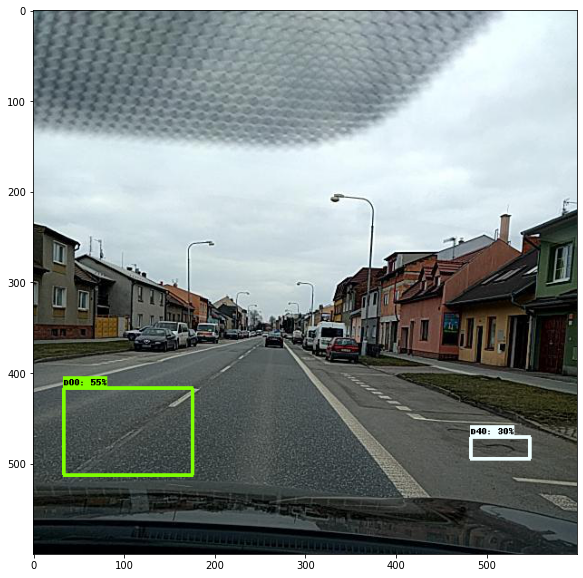

Running inference for /content/data/test/India_000028.jpg... Done


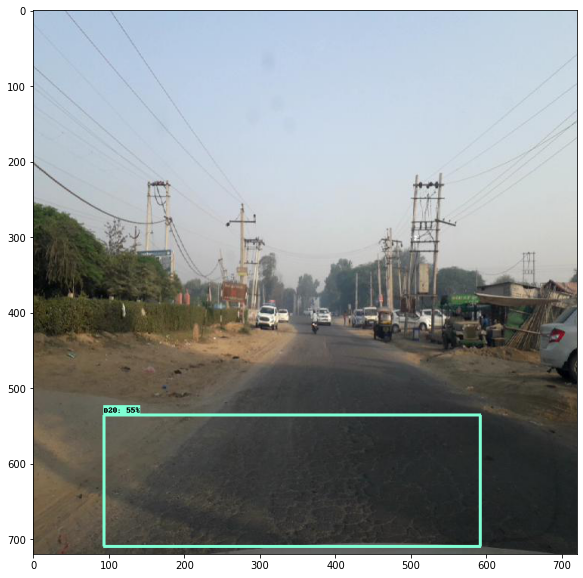

Running inference for /content/data/test/India_000486.jpg... Done


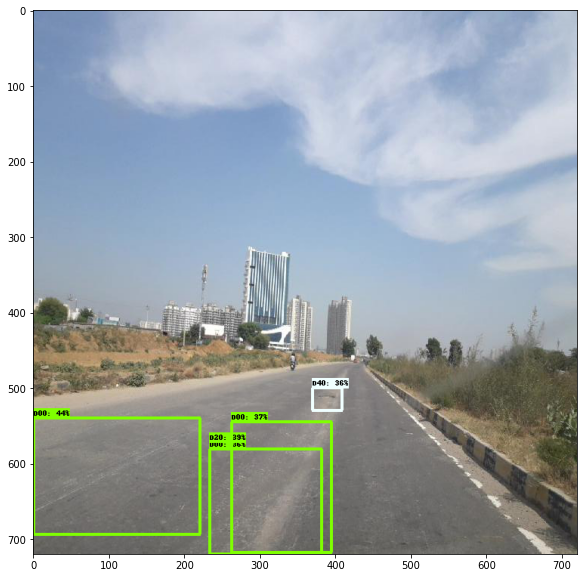

Running inference for /content/data/test/Japan_002077.jpg... Done


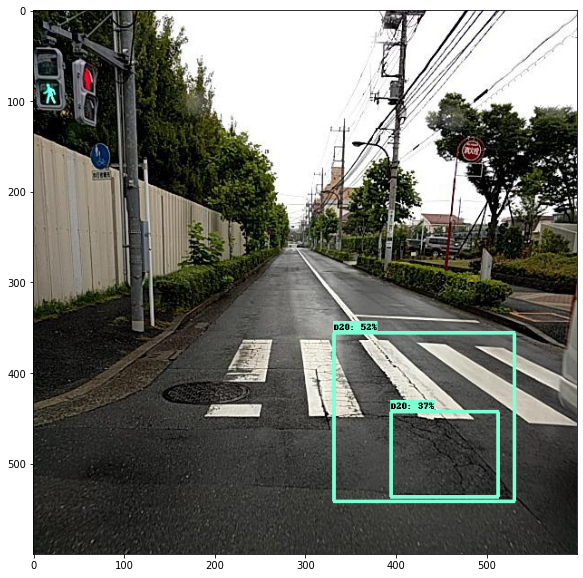

Running inference for /content/data/test/Japan_002855.jpg... Done


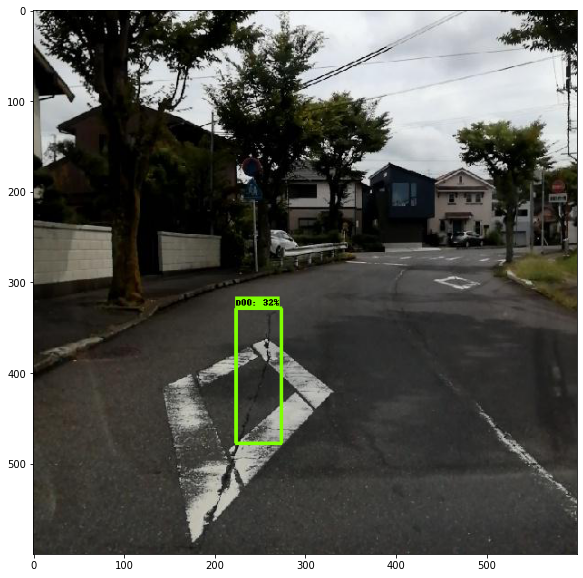

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

IMAGE_PATHS = ['/content/data/test/Czech_000083.jpg', '/content/data/test/India_000028.jpg', 
               '/content/data/test/India_000486.jpg', '/content/data/test/Japan_002077.jpg',
               '/content/data/test/Japan_002855.jpg']

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.30,
            agnostic_mode=False)

    %matplotlib inline
    fig = plt.figure(figsize = (10,10))
    plt.imshow(image_np_with_detections)
    print('Done')
    plt.show()

### Exporting model

In [ ]:
!mkdir /content/exported_model
!python /content/models/research/object_detection/exporter_main_v2.py \
    --input_type image_tensor \
    --pipeline_config_path /content/mobilenet_v2/pipeline.config  \
    --trained_checkpoint_dir /content/mobilenet_v2/  \
    --output_directory /content/exported_model


In [ ]:
!zip -r /content/mobilenet_v2.zip /content/exported_model/